# LDA Demonstration


In this notebook, we will build LDA models on following four datasets:
<ul><li>Consumer reviews of Amazon products Dataset</li><li>Demonetization Tweets Dataset</li><li>BBC News Dataset</li><li>Amazon Cell Phones and Accessories Reviews Dataset</li></ul>
We'll use the gensim implementation of LDA, though sklearn also comes with one. 

We will also use the library spacy for preprocessing (specifically lemmatisation). Though you can also perform lemmatisation in NLTK, it is slightly more convenient and less verbose in spacy. For visualising the topics and the word-topic distributions (interactively!), we'll use the 'pyLDAvis' module.

In [1]:
# import libraries  
import numpy as np
import pandas as pd


import nltk
from nltk import pos_tag_sents, word_tokenize
from nltk.tokenize import wordpunct_tokenize
from pprint import pprint
import re, random, os
import string

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

The code below creates a list of stop words. The 'string' module in python comes with a list of punctuation character, which we'll append to the builtin stopwords of NLTK.

In [2]:
# stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)

## Amazon Product Reviews Dataset - Echo/Alexa

For building topic models, let's experiment with the Amazon product reviews dataset. We have a list of 

In [3]:
df = pd.read_csv('7817_1.csv')

In [4]:
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


#### Reviews are for 54 different amazon products but we are focusing amazon echo

In [5]:
df['asins'].nunique()

54

In [6]:
# filter for product id = amazon echo
df = df[df['asins']=="B01BH83OOM"]
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
852,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",IMPORTANT UPDATE (3/8/17): As you read my orig...,"The Echo's Little Sister Is AMAZING!! 3,",NaN,NaN,Deanokat,NaN,8.416670e+11,1.75 lbs
853,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",It was just a few weeks ago that I was bemoani...,Tap Alexa on the go!,NaN,NaN,Heather A,NaN,8.416670e+11,1.75 lbs
854,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",The Amazon Tap is a portable Bluetooth speaker...,Amazon Tap Review - Best Bluetooth Speaker in ...,NaN,NaN,Quentin Moore,NaN,8.416670e+11,1.75 lbs
855,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,Look at this product as a portable speaker fir...,Great for what it does,NaN,NaN,Casey,NaN,8.416670e+11,1.75 lbs
856,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,This Amazon tap is not only a great Bluetooth ...,"Awesome, smart little portable speaker",NaN,NaN,Tazman3582,NaN,8.416670e+11,1.75 lbs


In [7]:
# tokenize words and clean 
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(data))

print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


In [8]:
# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# call functions

# remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['look', 'product', 'portable', 'speaker', 'second', 'big', 'reason', 'buy', 'standard', 'wifi', 'streaming', 'enable', 'home', 'stream', 'music', 'ease', 'voice', 'recognition', 'top', 'notch', 'really', 'shine', 'use', 'smart', 'home', 'accessory', 'problem', 'tap', 'microphone', 'button', 'listen', 'voice', 'want', 'big', 'sound', 'always', 'listen', 'feature', 'spend', 'extra', 'money']


In [10]:
# compare the nostop, lemmatised version with the original one
print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


In [11]:
# create dictionary and corpus
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[2])

[(3, 2), (13, 2), (16, 2), (17, 3), (20, 2), (24, 4), (29, 1), (31, 1), (35, 1), (48, 2), (51, 1), (56, 1), (60, 5), (70, 1), (82, 1), (85, 5), (88, 1), (90, 2), (95, 1), (96, 1), (97, 2), (99, 2), (100, 1), (108, 2), (112, 1), (116, 1), (120, 1), (128, 2), (131, 1), (134, 1), (141, 1), (142, 1), (143, 2), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 2), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1), (163, 2), (164, 1), (165, 1), (166, 3), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 2), (180, 1), (181, 1), (182, 2), (183, 2), (184, 5), (185, 1), (186, 3), (187, 2), (188, 1), (189, 3), (190, 1), (191, 1), (192, 1), (193, 1), (194, 6), (195, 1), (196, 1), (197, 2), (198, 1), (199, 2), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 2), (207, 1), (208, 1), (209, 2), (210, 1)]


In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('admit', 1),
  ('alexa', 1),
  ('allow', 1),
  ('amazon', 1),
  ('announce', 1),
  ('answer', 1),
  ('anyway', 1),
  ('app', 2),
  ('appealing', 1),
  ('associate', 1),
  ('avid', 1),
  ('aware', 1),
  ('back', 1),
  ('battery', 3),
  ('buy', 1),
  ('choose', 2),
  ('command', 1),
  ('control', 1),
  ('convenience', 1),
  ('cook', 1),
  ('day', 1),
  ('decide', 2),
  ('demand', 1),
  ('development', 1),
  ('device', 3),
  ('dot', 1),
  ('drain', 1),
  ('early', 2),
  ('easily', 2),
  ('echo', 1),
  ('enable', 1),
  ('especially', 1),
  ('fabulous', 1),
  ('financial', 1),
  ('firmware', 1),
  ('first', 1),
  ('free', 6),
  ('get', 1),
  ('give', 1),
  ('go', 1),
  ('hand', 6),
  ('high', 1),
  ('hope', 1),
  ('important', 1),
  ('introduce', 1),
  ('keep', 1),
  ('kitchen', 1),
  ('lack', 1),
  ('life', 1),
  ('listener', 1),
  ('little', 2),
  ('lot', 1),
  ('love', 1),
  ('major', 1),
  ('make', 1),
  ('maximum', 1),
  ('microphone', 1),
  ('mind', 1),
  ('minimal', 1),
  ('mode',

Building the Topic Model

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.068*"amazing" + 0.033*"easy" + 0.031*"little" + 0.030*"super" + '
  '0.026*"sync" + 0.024*"able" + 0.022*"beach" + 0.021*"weather" + '
  '0.017*"difficult" + 0.016*"assistant"'),
 (1,
  '0.061*"easy" + 0.057*"sound" + 0.043*"portability" + 0.038*"buy" + '
  '0.037*"echo" + 0.035*"feature" + 0.028*"house" + 0.028*"quality" + '
  '0.020*"need" + 0.020*"room"'),
 (2,
  '0.064*"loud" + 0.044*"decent" + 0.042*"expensive" + 0.035*"capability" + '
  '0.031*"glad" + 0.023*"upgrade" + 0.022*"mother" + 0.018*"issue" + '
  '0.015*"size" + 0.015*"online"'),
 (3,
  '0.043*"enjoy" + 0.039*"talk" + 0.033*"button" + 0.030*"alexa" + '
  '0.024*"thing" + 0.024*"fun" + 0.022*"put" + 0.021*"tap" + 0.020*"hold" + '
  '0.020*"lot"'),
 (4,
  '0.057*"great" + 0.048*"speaker" + 0.043*"use" + 0.037*"sound" + 0.035*"tap" '
  '+ 0.032*"love" + 0.031*"good" + 0.031*"music" + 0.028*"alexa" + '
  '0.026*"work"'),
 (5,
  '0.070*"set" + 0.037*"start" + 0.034*"actually" + 0.030*"radio" + '
  '0.027*"come" + 0

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.5350030156425705

Coherence Score:  0.4395692084830964


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.323406 -0.008689       1        1  46.545919
6      0.002890 -0.143587       2        1  14.346784
9      0.047303 -0.145590       3        1  11.817599
1      0.158946  0.255861       4        1   9.646718
3      0.068182 -0.139447       5        1   7.012594
5     -0.122254  0.000295       6        1   3.475321
8     -0.098321  0.066386       7        1   2.443773
0     -0.125367  0.054601       8        1   1.986329
2     -0.131949  0.027343       9        1   1.878890
7     -0.122838  0.032827      10        1   0.846073, topic_info=        Term        Freq       Total Category  logprob  loglift
82     sound  199.000000  199.000000  Default  30.0000  30.0000
85       tap  249.000000  249.000000  Default  29.0000  29.0000
52      love  156.000000  156.000000  Default  28.0000  28.0000
388     easy   57.000000   57.000000  Default  27.0000  27.0000
194  speaker  196.000000  196.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
988  opposed    0.349112    1.034970  Topic10  -5.3524   3.6856
987    cloud    0.740878    2.679666  Topic10  -4.5999   3.4867
108     come    1.275878   10.104258  Topic10  -4.0564   2.7030
256   pretty    0.717048   19.661969  Topic10  -4.6326   1.4610
304     feel    0.435570    7.726682  Topic10  -5.1311   1.8965

[468 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
102       2  0.184454    ability
102       4  0.737816    ability
277       2  0.575336       able
277       3  0.301367       able
277       8  0.109588       able
...     ...       ...        ...
1316      6  0.886995  worldwide
307       1  0.944900      worth
141       5  0.634650       year
141       6  0.380790       year
679       5  0.861321        yet

[533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 10, 2, 4, 6, 9, 1, 3, 8])

<b>NOTE:</b> λ parameter gives a balance the word-frequency in topic and the lift which the word got in topic. 
<ul><li>A word has higher lift if it has higher prevalence in this topic but not very high overall.</li> <li>If λ=1, the ranking is purely based on word-frequency.</li><li>If λ=0, the ranking is purely based on lift</li></ul>

## Hyperparameter Tuning - Number of Topics and Alpha
Let's now tune the two main hyperparameters - number of topics and alpha. The strategy is to tune these hyperparameters such that coherence score is maximized.

In [17]:
# Computer coherence score at various values of alpha and num_topics
# note that eta is fixed at 'auto', though one can tune that as well.
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                        id2word=dictionary,
                                                        num_topics=num_topics,
                                                        alpha=alpha,
                                                        eta='auto',
                                                        per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
    return model_list, coherence_values

In [18]:
# build models across a range of num_topics and alpha
num_topics_range = [2,6,10,15,20]
alpha_range = [0.001, 0.01, 0.1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        num_topics_range=num_topics_range,
                                                        alpha_range=alpha_range
                                                       )

In [19]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.001,2,0.483074
1,0.001,6,0.426459
2,0.001,10,0.447296
3,0.001,15,0.408166
4,0.001,20,0.381374
5,0.010,2,0.466576
6,0.010,6,0.414272
7,0.010,10,0.412728
8,0.010,15,0.403974
9,0.010,20,0.388661


In [20]:
# Plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i, val in enumerate(alpha_range):
        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]
        
        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel("num_topics")
        plt.ylabel("coherence value")
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

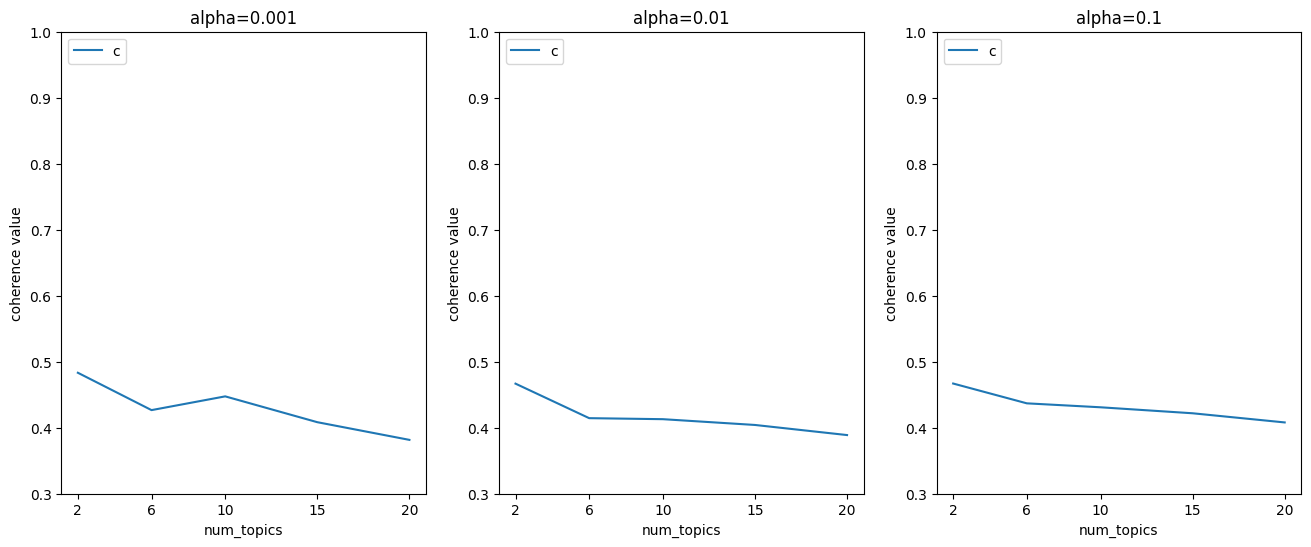

In [21]:
plot_coherence(coherence_df, alpha_range, num_topics_range)

### Inference from the plot:
<ul><li>In the first graph, when alpha=0.001, as the number of topics increases between 2 and 6, the coherence drops. Increses between 6 and 10, decreases between 10 and 20. Hence, 2-6 topics could be a good choice here.</li><li>In the second graph, when alpha=0.01, coherence score drops between 2 and 20. Hence, 2-6 topics could be a good choice.</li><li>Similary, In the third graph, when alpha=0.1, coherence score is drops significantly between 2 and 20. Hence, 2-6 is a good choice.</li>
</ul>
<b>Conclusion:</b> For higher alpha value, Topics are mixing at a much stronger rate. Therefore, coherence is dropping even faster. Therefore, alpha=0.001 is the best choice. And, number of topics should be between 2 and 6. Let's go with 4 topics.
    

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=4,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha=0.001,
                                            per_word_topics=True
                                           )

Let's now print the topics found in the dataset.

In [27]:
# Print 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"use" + 0.023*"speaker" + 0.023*"great" + 0.021*"tap" + '
  '0.019*"device" + 0.018*"easy" + 0.017*"music" + 0.015*"sound" + '
  '0.015*"able" + 0.012*"work"'),
 (1,
  '0.035*"sound" + 0.027*"good" + 0.027*"tap" + 0.024*"alexa" + 0.022*"music" '
  '+ 0.020*"speaker" + 0.020*"great" + 0.018*"love" + 0.016*"quality" + '
  '0.015*"buy"'),
 (2,
  '0.047*"love" + 0.032*"buy" + 0.026*"tap" + 0.020*"use" + 0.015*"gift" + '
  '0.013*"product" + 0.012*"daughter" + 0.011*"lot" + 0.010*"day" + '
  '0.009*"review"'),
 (3,
  '0.042*"great" + 0.033*"tap" + 0.025*"get" + 0.024*"speaker" + 0.022*"alexa" '
  '+ 0.022*"portable" + 0.022*"echo" + 0.020*"sound" + 0.020*"listen" + '
  '0.020*"button"')]


In [28]:
#coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Coherence Score: 0.3789472876563035


### Now let's visualise the topics.

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.062487  0.116819       1        1  32.570202
0      0.095158 -0.148362       2        1  30.794347
3      0.079068  0.045236       3        1  25.919994
2     -0.236713 -0.013693       4        1  10.715457, topic_info=            Term        Freq       Total Category  logprob  loglift
52          love  134.000000  134.000000  Default  30.0000  30.0000
96           use  171.000000  171.000000  Default  29.0000  29.0000
14           buy   89.000000   89.000000  Default  28.0000  28.0000
174       listen   56.000000   56.000000  Default  27.0000  27.0000
37           get  104.000000  104.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
283  portability    8.184895   43.235770   Topic4  -4.7366   0.5691
482        still    5.944893   14.931625   Topic4  -5.0563   1.3125
94           try    5.969603   16.018909   Topic4  -5.0522   1.2464
182         play    7.180695   55.850734   Topic4  -4.8675   0.1822
124         much    5.476220   28.137670   Topic4  -5.1384   0.5968

[269 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
277       2  0.983877        able
417       4  0.944528  absolutely
143       2  0.431497    activate
143       3  0.549178    activate
419       2  0.207224    actually
...     ...       ...         ...
307       1  0.919366       worth
141       2  0.119441        year
141       3  0.119441        year
141       4  0.716647        year
679       4  0.872004         yet

[356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

### Tweets on Demonetization

In [30]:
df = pd.read_csv("demonetization-tweets.csv", encoding = "ISO-8859-1")
print(df.shape)
df.head()

(14940, 16)


,Unnamed: 0,X,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted
0,1,1,RT @rssurjewala: Critical question: Was PayTM ...,False,0,NaN,2016-11-23 18:40:30,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",HASHTAGFARZIWAL,331,True,False
1,2,2,RT @Hemant_80: Did you vote on #Demonetization...,False,0,NaN,2016-11-23 18:40:29,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",PRAMODKAUSHIK9,66,True,False
2,3,3,"RT @roshankar: Former FinSec, RBI Dy Governor,...",False,0,NaN,2016-11-23 18:40:03,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",rahulja13034944,12,True,False
3,4,4,RT @ANI_news: Gurugram (Haryana): Post office ...,False,0,NaN,2016-11-23 18:39:59,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",deeptiyvd,338,True,False
4,5,5,RT @satishacharya: Reddy Wedding! @mail_today ...,False,0,NaN,2016-11-23 18:39:39,False,NaN,8.014954e+17,NaN,"<a href=""http://cpimharyana.com"" rel=""nofollow...",CPIMBadli,120,True,False


In [31]:
df.columns

Index(['Unnamed: 0', 'X', 'text', 'favorited', 'favoriteCount', 'replyToSN',
       'created', 'truncated', 'replyToSID', 'id', 'replyToUID',
       'statusSource', 'screenName', 'retweetCount', 'isRetweet', 'retweeted'],
      dtype='object')

In [32]:
# see randomly chosen sample tweets
df.text[random.randrange(len(df.text))]

'@WoCharLog @bhaiyyajispeaks When @SrBachchan supported Demonetization an international Chief Minister of India mock\x85 https://t.co/9wZaFZiAGq'

In [33]:
df.text[:10]

0    RT @rssurjewala: Critical question: Was PayTM ...
1    RT @Hemant_80: Did you vote on #Demonetization...
2    RT @roshankar: Former FinSec, RBI Dy Governor,...
3    RT @ANI_news: Gurugram (Haryana): Post office ...
4    RT @satishacharya: Reddy Wedding! @mail_today ...
5    @DerekScissors1: Indias #demonetization: #Bla...
6    RT @gauravcsawant: Rs 40 lakh looted from a ba...
7    RT @Joydeep_911: Calling all Nationalists to j...
8    RT @sumitbhati2002: Many opposition leaders ar...
9    National reform now destroyed even the essence...
Name: text, dtype: object

Note that many tweets have ..

In [34]:

# remove URLs
def remove_URL(x):
            return x.replace(r'https[a-zA-Z0-9]*', "", regex = True)


# clean tweet text
def clean_tweets(tweet_col):
    
    df = pd.DataFrame({'tweet':tweet_col})
    
    df['tweet'] = df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
    df['tweet'] = df['tweet'].replace("  ", " ")
    df['tweet'] = df['tweet'].replace(r'@[a-zA-Z0-9]*', '', regex=True)
    df['tweet'] = remove_URL(df['tweet'])
    df['tweet'] = df['tweet'].str.lower() 
    
    return(df)

cleaned_tweets = clean_tweets(df.text)
cleaned_tweets[:10]

,tweet
0,rt : critical question: was paytm informed abo...
1,rt _80: did you vote on #demonetization on mod...
2,rt : former finsec rbi dy governor cbdt chair ...
3,rt _news: gurugram haryana: post office employ...
4,rt : reddy wedding! _today cartoon #demonetiza...
5,: indias #demonetization: #blackmoney a sympt...
6,rt : rs 40 lakh looted from a bank in kishtwar...
7,rt _911: calling all nationalists to join\rwal...
8,rt : many opposition leaders are with on the ...
9,national reform now destroyed even the essence...


In [35]:
words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there",
                    "all","we","one","the","a","an","of","or","in","for","by","on","but","is","in",
                    "a","not","with","as","was","if","they","are","this","and","it","have","from","at",
                    "my","be","by","not","that","to","from","com","org","like","likes","so","said","from",
                    "what","told","over","more","other","have","last","with","this","that","such","when",
                    "been","says","will","also","where","why","would","today", "in", "on", "you", "r", "d", 
                    "u", "hw","wat", "oly", "s", "b", "ht", "rt", "p","the","th", "lol", ':']


# remove stop words, punctuations but retain hashtags (#)
stop_words = set(list(stopwords.words('english') + 
                      list(string.punctuation) +
                      words_remove)) - set('#')

data_words = list(sent_to_words(cleaned_tweets.tweet.values.tolist(), deacc=False))

# remove stopwords
def remove_stopwords(texts, stop_words=stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [36]:
# sample
data_lemmatized[:5]

[['critical',
  'question',
  'paytm',
  'inform',
  'clearly',
  'fishy',
  'require',
  'full',
  'disclosure',
  'amp'],
 ['vote', 'demonetization', 'survey', 'app'],
 ['former', 'finsec', 'demonetization', 'listen'],
 ['office',
  'employee',
  'provide',
  'cash',
  'exchange',
  'patient',
  'hospital',
  'demonetization',
  'tcougmxup'],
 ['reddy',
  'wedding',
  'cartoon',
  'demonetization',
  'reddywedde',
  'tcou',
  'glnrq']]

In [37]:
# create dictionary and corpus
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [38]:
# build models across a range of num_topics and alpha
num_topics_range = [2,6,10,15,20]
alpha_range = [0.001, 0.01, 0.1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        num_topics_range=num_topics_range,
                                                        alpha_range=alpha_range
                                                       )

In [39]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.001,2,0.420193
1,0.001,6,0.459143
2,0.001,10,0.473838
3,0.001,15,0.500908
4,0.001,20,0.491619
5,0.010,2,0.452607
6,0.010,6,0.460826
7,0.010,10,0.444367
8,0.010,15,0.470166
9,0.010,20,0.490718


In [40]:
# Plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i, val in enumerate(alpha_range):
        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]
        
        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel("num_topics")
        plt.ylabel("coherence value")
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

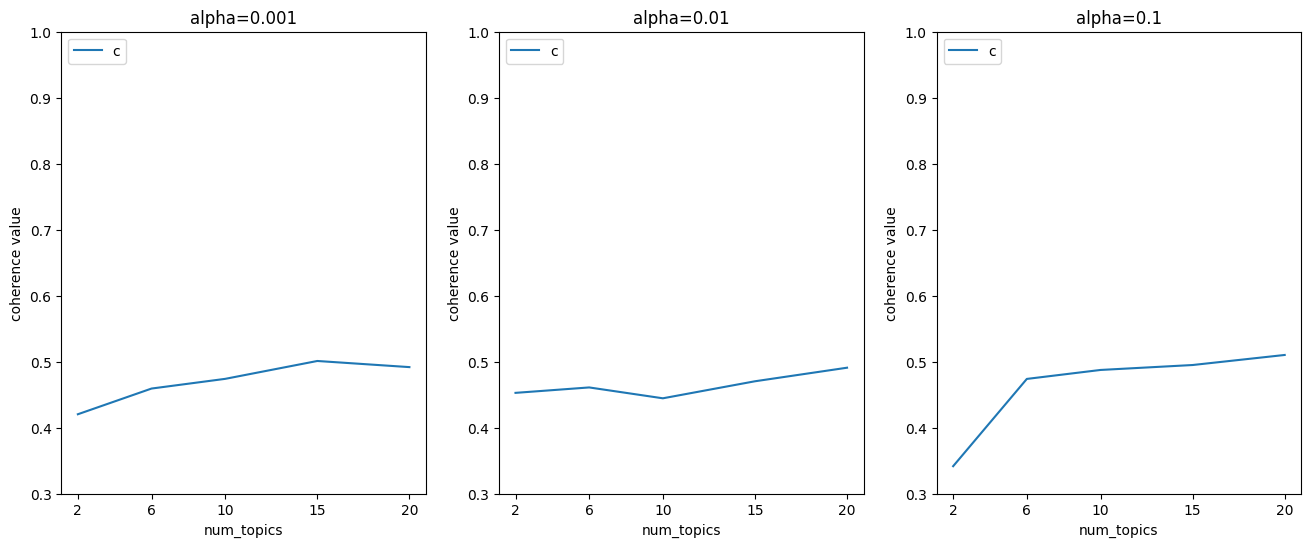

In [41]:
plot_coherence(coherence_df, alpha_range, num_topics_range)

### Inference from the plot:
<ul><li>In the first graph, when alpha=0.001, coherence score increases between 2 and 15 topics, decreases after 15. Hence, 15 topics could be a good choice here.</li><li>In the second graph, when alpha=0.01, coherence score is increases between 2 and 6, decreases between 6 and 10, increaes between 10 and 20. Hence, 6 topics could be a good choice. </li><li>Similary, In the third graph, when alpha=0.1, coherence score sharply increases between 2 and 6. Slowly increases after 6. Hence, 6 could be a good choice.</li>
</ul>
<b>Conclusion:</b> For higher alpha value, Topics are mixing at a much stronger rate. Therefore, coherence is dropping even faster. Therefore, alpha=0.001 is the best choice. And, number of topics should be 6.
    

In [47]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=6,
                                           alpha=0.001,
                                           per_word_topics=True)

In [48]:
lda_model.eta

array([0.16666667, 0.16666667, 0.16666667, ..., 0.16666667, 0.16666667,
       0.16666667], dtype=float32)

In [49]:
# print keywords 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.109*"demonetization" + 0.065*"actually" + 0.056*"make" + 0.052*"close" + '
  '0.051*"headline" + 0.051*"lack" + 0.039*"believe" + 0.033*"transparent" + '
  '0.033*"politicsit" + 0.033*"get"'),
 (1,
  '0.070*"supply" + 0.067*"s" + 0.064*"staff" + 0.053*"yearend" + '
  '0.050*"question" + 0.048*"action" + 0.044*"effect" + 0.028*"less" + '
  '0.023*"demonetization" + 0.023*"post"'),
 (2,
  '0.091*"demonetization" + 0.074*"cash" + 0.049*"due" + 0.034*"index" + '
  '0.022*"contract" + 0.021*"tco" + 0.020*"price" + 0.018*"industrial" + '
  '0.018*"production" + 0.018*"double"'),
 (3,
  '0.107*"demonetization" + 0.055*"poor" + 0.054*"keep" + 0.052*"quiet" + '
  '0.052*"prohibition" + 0.052*"men" + 0.049*"good" + 0.040*"youtube" + '
  '0.033*"report" + 0.029*"video"'),
 (4,
  '0.172*"demonetization" + 0.068*"implement" + 0.053*"shortage" + 0.051*"ed" '
  '+ 0.037*"end" + 0.033*"economy" + 0.028*"go" + 0.019*"day" + '
  '0.017*"goalpost" + 0.017*"royal"'),
 (5,
  '0.129*"demonetizatio

In [50]:
#coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Coherence Score: 0.45796203902350546


In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.149507 -0.312701       1        1  19.113479
4     -0.052914  0.045317       2        1  17.912101
2     -0.021650  0.173527       3        1  17.325507
5     -0.146791  0.159159       4        1  17.013092
1      0.369257 -0.046589       5        1  15.688767
0      0.001606 -0.018713       6        1  12.947054, topic_info=                Term         Freq         Total Category  logprob  loglift
17              cash  1356.000000   1356.000000  Default  30.0000  30.0000
823        implement  1287.000000   1287.000000  Default  29.0000  29.0000
1304          supply  1160.000000   1160.000000  Default  28.0000  28.0000
34                 s  1117.000000   1117.000000  Default  27.0000  27.0000
465            staff  1066.000000   1066.000000  Default  26.0000  26.0000
...              ...          ...           ...      ...      ...      ...
2610           night    62.066776     63.077398   Topic6  -5.4012   2.0282
6516      politicsit   460.072095    503.484603   Topic6  -3.3981   1.9541
6517     transparent   460.072095    503.484603   Topic6  -3.3981   1.9541
11    demonetization  1502.722463  11341.783501   Topic6  -2.2144   0.0231
6427         yearend   112.884083   1003.429056   Topic6  -4.8031  -0.1405

[242 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3147      4  0.989520        aadhaar
197       5  0.999433         action
1641      6  0.998708       actually
1737      1  0.998038             ad
6355      4  0.993391     adityanath
...     ...       ...            ...
143       6  0.991570            yet
4473      1  0.999186        youtube
6770      1  0.986863  youtubeisdead
6770      3  0.004745  youtubeisdead
6770      4  0.004745  youtubeisdead

[264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 6, 2, 1])

### BBC News Dataset

Link to Dataset: 
http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip

In [52]:
# reading the BBC news dataset

data_folder = "./bbc"
# os.chdir(data_folder)

folders = ["business","entertainment","politics","sport","tech"]

x = []
y = []

for folder in folders:
    files = os.listdir(data_folder + "/" + folder)
    for text_file in files:
        file_path = data_folder + "/" + folder + "/" + text_file
        with open(file_path, 'rb') as f:
            data = f.read()
            x.append(data)
            y.append(folder)

data = {'news': x, 'type': y}       
df = pd.DataFrame(data)
df.to_csv('bbc_data.csv', index=False)            

In [53]:
df.head()

,news,type
0,b'UK economy facing \'major risks\'\n\nThe UK ...,business
1,b'Aids and climate top Davos agenda\n\nClimate...,business
2,b'Asian quake hits European shares\n\nShares i...,business
3,b'India power shares jump on debut\n\nShares i...,business
4,"b""Lacroix label bought by US firm\n\nLuxury go...",business


In [54]:
df.type.astype('category').value_counts()

type
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [55]:
# convert to list
data = df['news'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# lemmatize
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create corpus
texts = data_lemmatized

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [56]:
# build models across a range of num_topics and alpha
num_topics_range = [2,6,10,15,20]
alpha_range = [0.001, 0.01, 0.1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        num_topics_range=num_topics_range,
                                                        alpha_range=alpha_range
                                                       )

In [57]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.001,2,0.367540
1,0.001,6,0.346124
2,0.001,10,0.343348
3,0.001,15,0.398430
4,0.001,20,0.337143
5,0.010,2,0.376591
6,0.010,6,0.353589
7,0.010,10,0.319482
8,0.010,15,0.358631
9,0.010,20,0.345595


In [58]:
# Plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i, val in enumerate(alpha_range):
        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]
        
        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel("num_topics")
        plt.ylabel("coherence value")
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

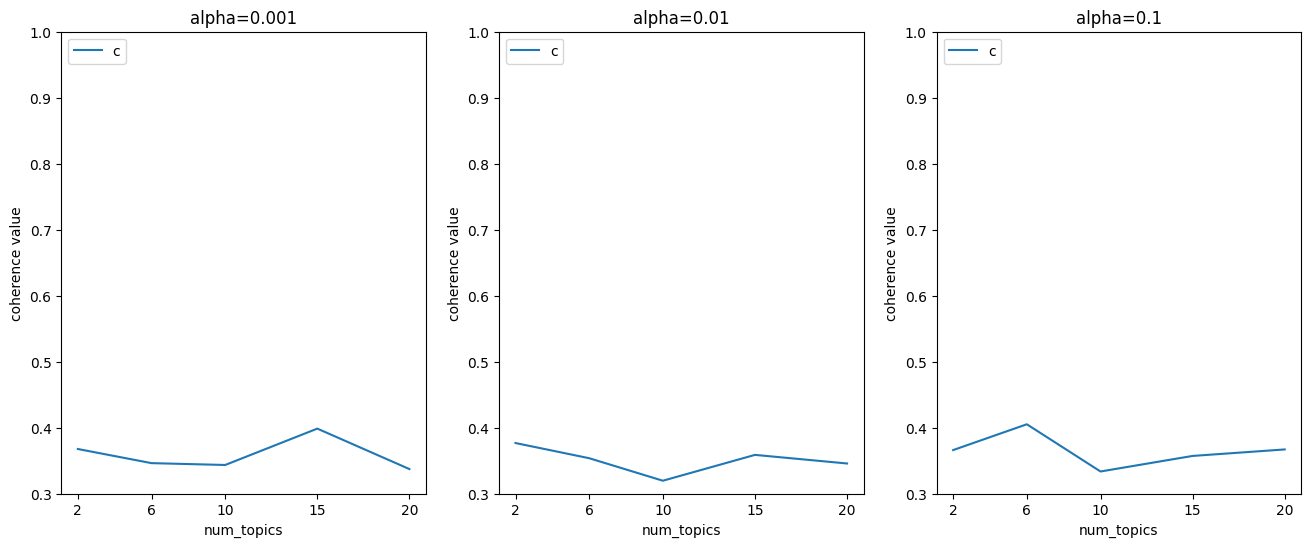

In [59]:
plot_coherence(coherence_df, alpha_range, num_topics_range)

### Inference from the plot:
<ul><li>In the first graph, when alpha=0.001, coherence score decreasess slowly between 2 and 10 topics, increase between 10 and 15, decreses after 15. Hence, 2 to 6 topics could be a good choice here.</li><li>In the second graph, when alpha=0.01, coherence score decreases between 2 and 10, increases between 10 and 15, decreases after 15. Hence, 2 to 6 topics could be a good choice.  </li><li>In the third graph, when alpha=0.1, coherence score increases between 2 and 6, decreases between 6 and 10, increases after 15. Hence, 2 to 6 topics could be a good choice.</li>
</ul>
<b>Conclusion:</b> For higher alpha value, Topics are mixing at a much stronger rate. Therefore, coherence is dropping even faster. Therefore, alpha=0.001 is the best choice. And, number of topics should be 4.
    

In [60]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.001,
                                           per_word_topics=True)

In [61]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.042190188021133

Coherence Score:  0.4150249299691277


In [62]:
# print keywords 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"make" + 0.006*"new" + 0.006*"people" + 0.005*"go" + 0.004*"say" + '
  '0.004*"government" + 0.004*"year" + 0.004*"issue" + 0.004*"work" + '
  '0.004*"take"'),
 (1,
  '0.012*"film" + 0.012*"good" + 0.010*"year" + 0.010*"game" + 0.006*"make" + '
  '0.006*"show" + 0.006*"top" + 0.006*"take" + 0.006*"play" + 0.006*"include"'),
 (2,
  '0.032*"game" + 0.014*"play" + 0.010*"player" + 0.010*"year" + 0.009*"time" '
  '+ 0.009*"go" + 0.009*"first" + 0.008*"win" + 0.008*"get" + 0.007*"team"'),
 (3,
  '0.014*"use" + 0.012*"people" + 0.010*"technology" + 0.010*"phone" + '
  '0.009*"mobile" + 0.008*"user" + 0.007*"service" + 0.007*"music" + '
  '0.006*"software" + 0.006*"new"')]


In [63]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.037050 -0.195708       1        1  42.446054
3      0.232635  0.081028       2        1  24.261547
1     -0.096316  0.107499       3        1  16.908702
2     -0.173369  0.007182       4        1  16.383698, topic_info=            Term         Freq        Total Category  logprob  loglift
2781        game  2493.000000  2493.000000  Default  30.0000  30.0000
649         play  1342.000000  1342.000000  Default  29.0000  29.0000
1590  technology   907.000000   907.000000  Default  28.0000  28.0000
4042        film   712.000000   712.000000  Default  27.0000  27.0000
482       mobile   826.000000   826.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
619         week   281.840326   767.789683   Topic4  -5.3471   0.8067
293         make   378.047666  2236.904092   Topic4  -5.0534   0.0311
26          good   315.315837  1219.309725   Topic4  -5.2348   0.4564
230        world   286.498381  1025.719901   Topic4  -5.3307   0.5335
445         look   259.882393   806.260692   Topic4  -5.4282   0.6767

[296 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7164      3  0.992729  acclaim
1016      1  0.802024   action
1016      3  0.113561   action
1016      4  0.085171   action
3615      3  0.987079    actor
...     ...       ...      ...
101       3  0.271908     year
101       4  0.248149     year
1423      1  0.244504    young
1423      2  0.019405    young
1423      3  0.733512    young

[474 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

## Amazon Cell Phones and Accessories Reviews


Link to Dataset: 
https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz

In [64]:
# all electronic products
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Cell_Phones_and_Accessories_5.json.gz')

In [65]:
df.shape

(194439, 9)

In [66]:
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3.0,Cute,1381536000,"10 12, 2013"
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,"[0, 0]",Came just as described.. It doesn't come unstu...,5.0,best thing ever..,1377129600,"08 22, 2013"
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,"[1, 2]",it worked for the first week then it only char...,1.0,not a good Idea,1384992000,"11 21, 2013"
8,A2JWEDW5FSVB0F,3998899561,Adam,"[2, 3]","Good case, solid build. Protects phone all aro...",5.0,Solid Case,1380067200,"09 25, 2013"
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5.0,Perfect Case,1396483200,"04 3, 2014"


In [67]:
# convert to list
data = df['reviewText'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# lemmatize
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create corpus
texts = data_lemmatized

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [68]:
# build models across a range of num_topics and alpha
num_topics_range = [2,6,10,15,20]
alpha_range = [0.001, 0.01, 0.1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        num_topics_range=num_topics_range,
                                                        alpha_range=alpha_range
                                                       )

In [69]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.001,2,0.380588
1,0.001,6,0.430467
2,0.001,10,0.434264
3,0.001,15,0.459936
4,0.001,20,0.443381
5,0.010,2,0.404495
6,0.010,6,0.429721
7,0.010,10,0.440635
8,0.010,15,0.437330
9,0.010,20,0.420319


In [70]:
# Plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i, val in enumerate(alpha_range):
        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]
        
        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel("num_topics")
        plt.ylabel("coherence value")
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

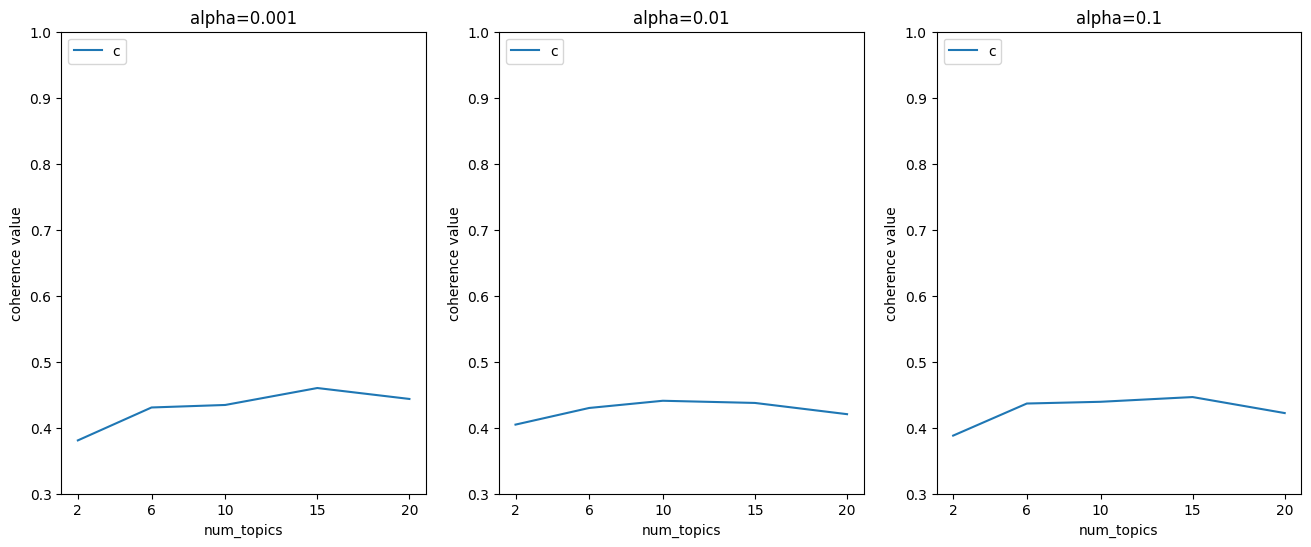

In [71]:
plot_coherence(coherence_df, alpha_range, num_topics_range)

### Inference from the plot:
<ul><li>In the first graph, when alpha=0.001, coherence score increasess slowly between 2-15 topics, decreses after 15. Hence, 15 topics could be a good choice here.</li><li>In the second graph, when alpha=0.01, coherence score slowly increases between 2 and 10, decreases between 10 and 15, decreases after 15. Hence, 10 topics could be a good choice.  </li><li>Similary, In the third graph, when alpha=0.1, coherence score rapidly increases between 2 and 6, slowly increases between 6 and 15, decreases after 15. Hence, 6 topics could be a good choice.</li>
</ul>
<b>Conclusion:</b> For higher alpha value, Topics are mixing at a much stronger rate. Therefore, coherence is dropping even faster. Therefore, alpha=0.001 is the best choice. And, number of topics should be 6.
    

In [72]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.001,
                                           per_word_topics=True)

In [73]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.224650  0.089177       1        1  38.749247
4      0.042295 -0.068904       2        1  20.676527
2      0.108173  0.092182       3        1  15.156838
3      0.183811 -0.041902       4        1  12.615127
0     -0.215160 -0.339341       5        1   8.204360
5     -0.343769  0.268789       6        1   4.597901, topic_info=       Term           Freq          Total Category  logprob  loglift
78     case  155461.000000  155461.000000  Default  30.0000  30.0000
70   charge   91974.000000   91974.000000  Default  29.0000  29.0000
48   screen   51203.000000   51203.000000  Default  28.0000  28.0000
256  review   37471.000000   37471.000000  Default  27.0000  27.0000
14    phone  189013.000000  189013.000000  Default  26.0000  26.0000
..      ...            ...            ...      ...      ...      ...
53     help    3199.297316    6664.444915   Topic6  -4.6916   2.3457
318     top    2956.844188   10662.522550   Topic6  -4.7704   1.7970
684    hard    2933.255861   14967.948843   Topic6  -4.7784   1.4498
595    part    2736.009145   10446.692349   Topic6  -4.8480   1.7398
864   large    2577.809278    9382.939083   Topic6  -4.9076   1.7876

[333 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
462       6  0.999803   ability
241       1  0.999945      able
260       2  0.999830   adapter
104       3  0.999930       add
2082      6  0.999777       air
...     ...       ...       ...
1857      6  0.999564      wipe
1072      2  0.999936  wireless
21        1  0.866833      work
21        4  0.133150      work
63        1  0.999902     worth

[440 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1, 6])